In [138]:
# basic library imports
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from tqdm import tqdm

# encoding the classes
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# librosa for audion feature extraction
import librosa
import gc
import pickle
import random
from multiprocessing import Pool
from PIL import Image
from random import shuffle
from sklearn.model_selection import train_test_split


# keras components for constructing the model
import tensorflow as tf
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import (Dense, Input, Dropout, Convolution1D, 
MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate)

In [115]:
# audio file length and batch size for generator
sampling_freq = 16000
duration = 4
input_length = sampling_freq*duration
batch_size = 32

### Utility functions

In [116]:
def input_to_target(base_data_path = 'data/'):

    # audio files and their corresponding labels
    train_path = base_data_path + "train/Train/*.wav"
    train_label_path = base_data_path +  "train.csv"
    test_path =  base_data_path + "test/Test/*.wav"

    # input
    train_files = glob.glob(train_path)
    train_files = pd.DataFrame({'train_file_paths': train_files})
    train_files['ID'] = train_files['train_file_paths'].apply(lambda x:x.split('/')[-1].split('.')[0])
    train_files['ID'] = train_files['ID'].astype(int)
    train_files = train_files.sort_values(by='ID')
    test_files = glob.glob(test_path)

    # target
    train_labels = pd.read_csv(train_label_path)
    train_file_to_label = train_files.merge(train_labels, on= "ID", how='inner')

    # encoding the classes
    int_encode = LabelEncoder()
    onehot_encode = OneHotEncoder(sparse=False, categories='auto')
    train_file_to_label['class_int_encode'] = int_encode.fit_transform(train_file_to_label['Class'])
    onehot_target = onehot_encode.fit_transform(train_file_to_label['class_int_encode'].values.reshape(-1,1))
    
    return train_file_to_label, onehot_target


def audio_normalization(data):
    
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] 
    
    if len(data)>input_length:
        
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length+offset)]
              
    else:
        
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
            
        else:
            offset = 0
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = audio_normalization(data)
    return data

In [228]:
train_file_to_label, onehot_target = input_to_target()
train_file_to_label.head()

,train_file_paths,ID,Class,class_int_encode
0,data/train/Train/0.wav,0,siren,8
1,data/train/Train/1.wav,1,street_music,9
2,data/train/Train/2.wav,2,drilling,4
3,data/train/Train/3.wav,3,siren,8
4,data/train/Train/4.wav,4,dog_bark,3


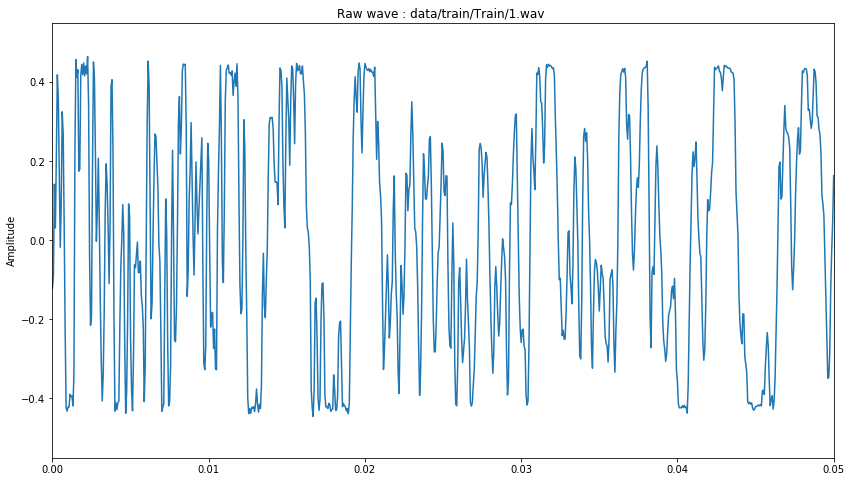

In [227]:
data_base = load_audio_file(train_file_to_label['train_file_paths'][1], input_length=16000*4)
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave : %s ' % (train_file_to_label['train_file_paths'][1]))
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 4, 16000*4), data_base)
plt.xlim(0,0.05)
plt.show()

In [129]:
from 